In [0]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import os

In [0]:
base_dir = os.path.abspath('/content/drive/My Drive/_data')
data_dir = os.path.join(base_dir, 'Stocks-Data')

In [0]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

In [24]:
# Load or download the data
try:
    data = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
    print('File not found...downloading the GOOG data')
    data = DataReader('GOOG', 'yahoo', start_date, end_date)
    data.to_pickle(os.path.join(data_dir, SRC_DATA_FILENAME))

File not found...downloading the GOOG data


In [0]:
goog_data = data.tail(620)
lows = goog_data['Low']
highs = goog_data['High']

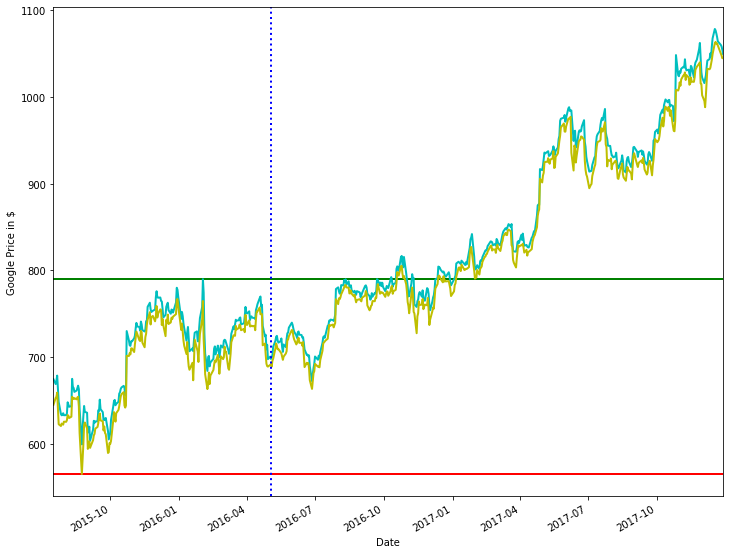

In [23]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(111, ylabel='Google Price in $')
highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)

plt.hlines(highs.head(200).max(), lows.index.values[0], lows.index.values[-1], color='g', lw=2)
plt.hlines(lows.head(200).min(), lows.index.values[0], lows.index.values[-1], color='r', lw=2)

plt.axvline(x=lows.index.values[200], color='b', lw=2, ls=':')

plt.show()

In [27]:
goog_data_signal = pd.DataFrame(index=data.index)
goog_data_signal['price'] = data['Adj Close']
goog_data_signal.head()

,price
Date,
2014-01-02,554.481689
2014-01-03,550.436829
2014-01-06,556.573853
2014-01-07,567.303589
2014-01-08,568.484192


In [0]:
def trading_support_resistance(data, bin_width=20):
    data = data.copy()
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support = 0
    in_resistance = 0

    for x in range((bin_width - 1) + bin_width, len(data)):
        data_section = data[x - bin_width:x+1]
        support_level = min(data_section['price'])
        resistance_level = max(data_section['price'])
        range_level = resistance_level - support_level
        data['res'][x] = resistance_level
        data['sup'][x] = support_level
        data['sup_tolerance'][x] = support_level + (0.2 * range_level)
        data['res_tolerance'][x] = resistance_level - (0.2 * range_level)

        if data['price'][x] >= data['res_tolerance'][x] and data['price'][x] <= data['res'][x]:
            in_resistance += 1
            data['res_count'][x] = in_resistance
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support = 0
            in_resistance = 0

        if in_resistance > 2:
            data['signal'][x] = 1
        elif in_support > 2:
            data['signal'][x] = 0
        else:
            data['signal'][x] = data['signal'][x-1]
    
    data['positions'] = data['signal'].diff()

    return data

In [0]:
goog_data_signal = trading_support_resistance(goog_data_signal)

In [45]:
goog_data_signal.iloc[35:55]

,price,sup_tolerance,res_tolerance,sup_count,res_count,sup,res,positions,signal
Date,,,,,,,,,
2014-02-24,603.991089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-25,607.722107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-26,607.806763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-27,607.328613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,605.555237,573.240356,599.165161,NaN,1.0,564.598755,607.806763,NaN,NaN
2014-03-03,599.099426,573.240356,599.165161,NaN,NaN,564.598755,607.806763,NaN,NaN
2014-03-04,605.186584,573.240356,599.165161,NaN,1.0,564.598755,607.806763,NaN,NaN
2014-03-05,606.855347,575.125269,599.636389,NaN,2.0,566.954895,607.806763,NaN,NaN
2014-03-06,607.527832,577.133765,600.138513,NaN,3.0,569.465515,607.806763,NaN,1.0


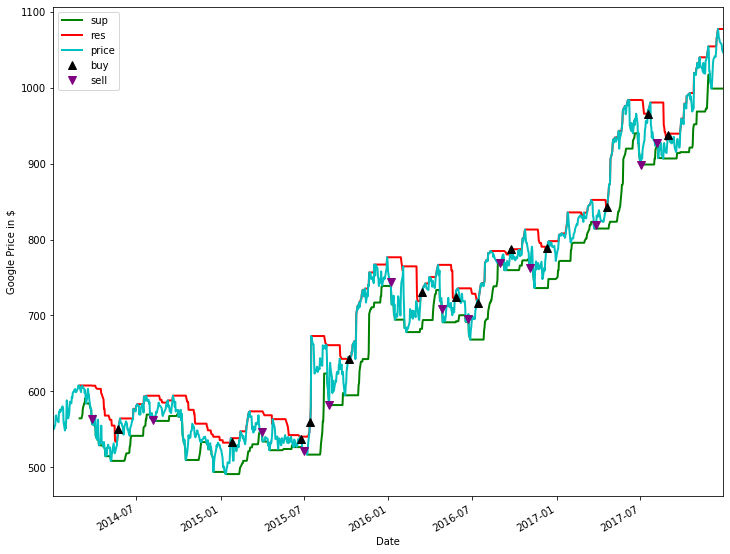

In [56]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(111, ylabel='Google Price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2)
goog_data_signal['res'].plot(ax=ax1, color='r', lw=2)
goog_data_signal['price'].plot(ax=ax1, color='c', lw=2)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1].index,
         goog_data_signal.price[goog_data_signal.positions == 1], 
         '^', markersize=8, color='k', label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1].index,
         goog_data_signal.price[goog_data_signal.positions == -1],
         'v', markersize=8, color='purple', label='sell')
plt.legend()
plt.show()